In [1]:
#from sklearn import linear_model
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import torch  as tc


# v= Constante

## ML-std

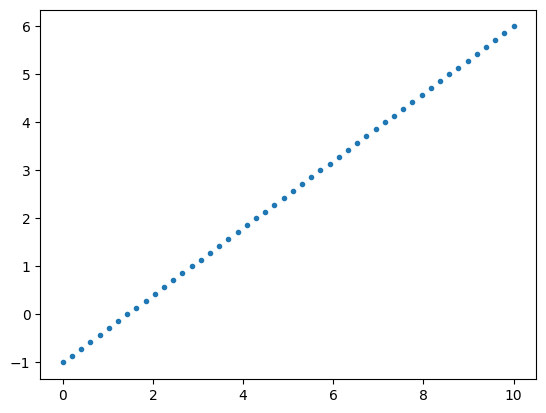

In [ ]:
def eq_movimento(x_0,v_,t_):
    return  x_0 + v_*t_

t = np.linspace(0,10)
plt.plot(t,eq_movimento(x_0=-1,v_=0.7,t_=t),".")

plt.show()

Com o .LinearRegression() do sckitleanr podemos aprender os parâmetros(posição inicial e velocidade)

In [ ]:
t = np.linspace(0,10).reshape((-1, 1))
y = eq_movimento(x_0=-1,v_=0.7,t_=t)

reg = linear_model.LinearRegression()
reg.fit(t,y)# FITANDO
print("a: ",reg.coef_)
print("b: ",reg.intercept_)


a:  [[0.7]]
b:  [-1.]


Com o DecisionTreeRegressor podemos aprender a função

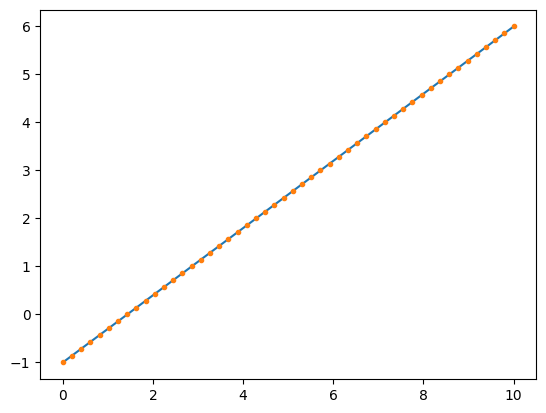

In [ ]:
from sklearn.tree import DecisionTreeRegressor

RT = DecisionTreeRegressor(criterion = "squared_error")
RT.fit(t,y)# FITANDO

t_tes = np.linspace(0,10).reshape((-1, 1))
predição = RT.predict(t_tes)

plt.plot(t,y,"-")
plt.plot(t_tes,predição,".")

plt.show()

## ML-NN

In [2]:
class Regressao_0(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_3 = nn.Linear(neuronio,1)
        self.A_layer = nn.ReLU()

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_3(x))
        return x
    
class Regressao_1(nn.Module):
    def __init__(self, neuronio,output=1, creat_p=False):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_2 = nn.Linear(neuronio,neuronio)
        self.layer_3 = nn.Linear(neuronio,output)
        self.A_layer = nn.Tanh()
        if creat_p == True:
            self.velocidade = nn.Parameter(tc.randn(1))

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_2(x))
        x = self.layer_3(x)
        return x

In [3]:
class Loss_parametro(nn.Module):
    def __init__(self,inputs,targets):
        super(Loss_parametro, self).__init__()
        self.t = inputs
        self.x = targets
    def forward(self,outputs):
        # função 1° grau: x- x0 -vt = 0
        funcao_1_grau = self.x - self.x[0] - outputs*self.t
        loss_solution = tc.mean( abs(funcao_1_grau) )
        # podemos impor que independe do input o parametro deve ser igual
        v_medio = outputs.mean()
        loss_const = tc.mean((outputs - v_medio) ** 2)
        # testar varância
        return loss_solution + loss_const

class Loss_edo(nn.Module):
    """
    Loss fucntio com a implementação da eqo e condição inicial para aprender a funçao.
    Args:
        nn (_type_): _description_
    """
    def __init__(self,rede_neural,ic,velocidade,inputs):
        super(Loss_edo, self).__init__()
        self.rede = rede_neural
        self.v = velocidade
        self.t = inputs
        self.x0 = ic
    def forward(self,y_pred):
        dydt = tc.autograd.grad(y_pred, self.t, grad_outputs=tc.ones_like(y_pred), create_graph=True)[0]
        # condição inicial x(0)
        loss_ic = (y_pred[0] - self.x0)**2
        # Derivada da função em relação a entrada
        # edo : dx/dt = v
        # estamos usando [1:] para escluir a condição inicial
        loss_edo = tc.mean( (dydt - self.v )**2 )

        return loss_ic + loss_edo

class Loss_edo2(nn.Module):
    """
    Nessa loss function vamos usar os dados experimentais para descobri qual é a
    edo , isso significa que vamos descobri os parâmetro da edo.
    """
    def __init__(self,inputs,data):
        super(Loss_edo2, self).__init__()
        #self.rede = rede_neural
        #self.data_= data
        #self.t    = inputs
        self.dydt = tc.autograd.grad(data,inputs, grad_outputs=tc.ones_like(inputs), create_graph=True)[0]
    def forward(self,parametro):
        # edo : d(Data)/dt = v
        loss_edo = tc.mean( (self.dydt - parametro )**2 )

        # podemos impor que independe do input o parametro deve ser igual
        loss_const = tc.mean((parametro - parametro.mean()) ** 2)
        return loss_edo +loss_const
  
class Loss_edo3(nn.Module):
    """
        Loss fuction com condição de inicial, edo e dados.
        Utilizada para aprender a função e o parametro da edo
        c_1 <-> Condição inicial x(0) 
        c_2 <-> Edo : dx/dt = v.
        c_3 <-> Edo : d(data)/dt = v
        c_4 <-> data - solution
    """
    def __init__(self,inputs,data, ic, lambdas):
        super(Loss_edo3, self).__init__()
        #self.rede = rede_neural
        self.data_ = data
        self.t     = inputs
        self.IC    = ic
        self.c1    = lambdas[0]
        self.c2    = lambdas[1]
        self.c3    = lambdas[2]
        self.c4    = lambdas[3]
        # Devidadas dos dados 
        self.dy_dt = tc.autograd.grad(data , inputs, grad_outputs=tc.ones_like(data), create_graph=True)[0]   

    def forward(self,y_preds,parametro):
        # Derivadas da rede 
        dydt  = tc.autograd.grad(y_preds, self.t, grad_outputs=tc.ones_like(self.t),create_graph=True)[0]
        
        # Condição inicial x(0).
        loss_ic = (y_preds[0] - self.IC )**2

        # Edo : dx/dt = v.
        loss_edo = tc.mean( (dydt - parametro)**2 )

        # Usando os dado na equação diferencial.
        loss_data_edo = tc.mean( (self.dy_dt - parametro )**2 )

        # Fazer (data - solution)**2
        loss_data_solution =  tc.mean( (self.data_ - y_preds)**2 )

        return tc.sum( self.c1*loss_ic + self.c2*loss_edo  + self.c3*loss_data_edo + self.c4*loss_data_solution) 

In [4]:
def eq_movimento(x_0,v_,t_):
    return  x_0 + v_*t_

# Criando os dados de treino
x_train = tc.linspace(0,1,30,device="cuda").reshape(-1,1)
y_train =  eq_movimento(x_0=-1,v_=0.7,t_=x_train)

| Train Loss: 9.854283007371123e-07 |


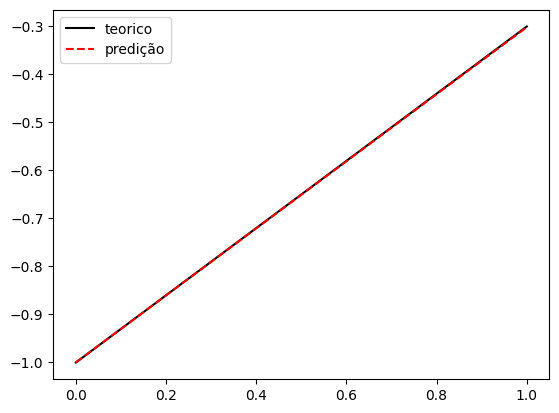

In [ ]:
# Aprendendo o valor da constante
model = Regressao_0(10).to("cuda") # rede dos parametros
opt    = tc.optim.Adam(params=model.parameters(),lr=0.01) # rede dos parametros
loss_f  = Loss_parametro(x_train,y_train)

epochs = 5000
for epoch in range(epochs):
    model.train()
    y_preds = model(x_train)
    loss = loss_f(outputs=y_preds)
    opt.zero_grad()
    loss.backward()
    opt.step()

mse_loss = nn.MSELoss()
model.eval()
with tc.inference_mode():
    prediçao = model(x_train)
    loss = mse_loss(y_train[0] + prediçao*x_train,y_train)
    print(f"| Train Loss: {loss} |")
plt.plot(x_train.cpu(),y_train.cpu(),"k-" ,label="teorico")
plt.plot(x_train.cpu(),y_train[0].cpu() + prediçao.cpu().mean()*x_train.cpu(),"r--",label="predição" )
plt.legend()
plt.show()
# Histograma da velocidade

Aprendendo a função com a edo

| Train Loss: 2.7185380613303778e-09 |


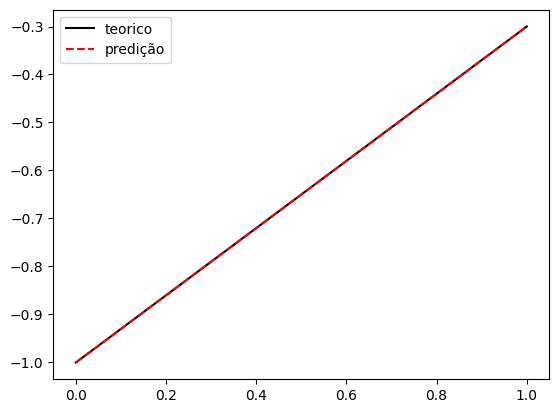

In [ ]:
model = Regressao_1(30).to("cuda") # rede da função
opt = tc.optim.Adam(params=model.parameters(),lr=0.01)  # rede da função
loss_f  = Loss_edo(model,-1,0.7,x_train)

epochs = 1000
for epoch in range(epochs):
    x_train.requires_grad_(True)
    model.train()
    y_preds = model(x_train)
    loss = loss_f(y_preds)
    opt.zero_grad()
    loss.backward()
    opt.step()

#rede 1 é a função
loss_fn = nn.MSELoss()
model.eval()
with tc.inference_mode():
    prediçao = model(x_train)
    loss = loss_fn( prediçao,y_train)
    print(f"| Train Loss: {loss} |")

plt.plot(x_train.cpu().detach().numpy(),y_train.cpu().detach().numpy(),"k-" ,label="teorico")
plt.plot(x_train.cpu().detach().numpy(), prediçao.cpu().detach().numpy(),"r--",label="predição" )
plt.legend()
plt.show()

2.850711e-07 parametro: 0.69999766
| Train Loss: 1.834503035591517e-12 |


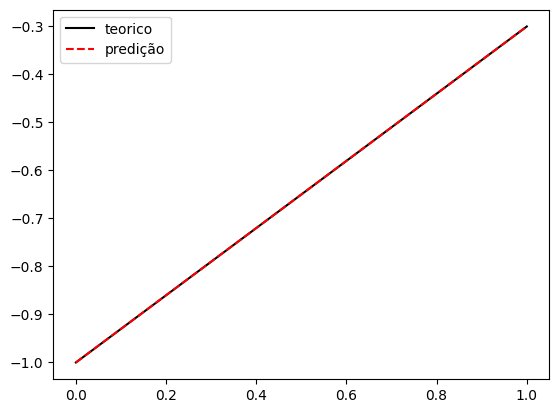

In [ ]:
# Vamos aprender o parâmetro da equação com os dados experimentais

# Criando os dados de treino
x_train = tc.linspace(0,1,30,requires_grad=True,device='cuda').reshape(-1,1)
y_train =  eq_movimento(x_0=-1,v_=0.7,t_=x_train)

model = Regressao_1(10).to("cuda") # rede da função
opt = tc.optim.Adam(params=model.parameters(),lr=0.01)  # rede da função
loss_f  = Loss_edo2(x_train,y_train)


for epoch in range(2000):
    x_train.requires_grad_(True)
    model.train()
    y_preds = model(x_train)
    loss = loss_f(y_preds)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss.cpu().detach().numpy(),"parametro:",y_preds.mean().cpu().detach().numpy())

loss_fn = nn.MSELoss()
func = y_train[0] + model(x_train).mean()*x_train
loss = loss_fn( func,y_train)
print(f"| Train Loss: {loss} |")

func = func.cpu().detach().numpy()
plt.plot(x_train.cpu().detach().numpy(),y_train.cpu().detach().numpy(),"k-" ,label="teorico")
plt.plot(x_train.cpu().detach().numpy(), func,"r--",label="predição" )
plt.legend()
plt.show()

Usando o parametro parte da rede 


| Train Loss: 4.614070348907262e-05 | parametro: [9.999951]


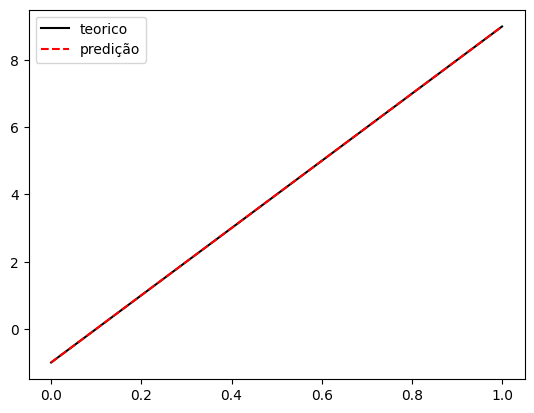

In [6]:
x_train = tc.linspace(0,1,50,requires_grad=True,device='cuda').reshape(-1,1)
y_train =  eq_movimento(x_0=-1,v_=10,t_=x_train)

model = Regressao_1( 5,True).to("cuda") 
opt = tc.optim.Adam( params = model.parameters(),lr=0.01)  
Loss_edo3 = Loss_edo3(x_train,y_train, -1,[1,1,1,0])
LOSS = []
for epoch in range(5000):
    model.train()
    y_preds = model(x_train)     # output da rede
    parametro = model.velocidade # chamando o parametro 

    loss = Loss_edo3(y_preds,parametro)
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

y_preds = model(x_train)     # output da rede
parametro = model.velocidade # chamando o parametro 
print(f"\n| Train Loss: {loss.cpu().detach().numpy()} |","parametro:",parametro.cpu().detach().numpy())

plt.plot(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),"k-" ,label="teorico")
plt.plot(x_train.cpu().detach().numpy(), y_preds.cpu().detach().numpy(),"r--",label="predição" )
plt.legend()
plt.show()


Usando o parametro com saida da rede 


| Train Loss: 1.803781856324349e-06 | parametro: 0.99995255


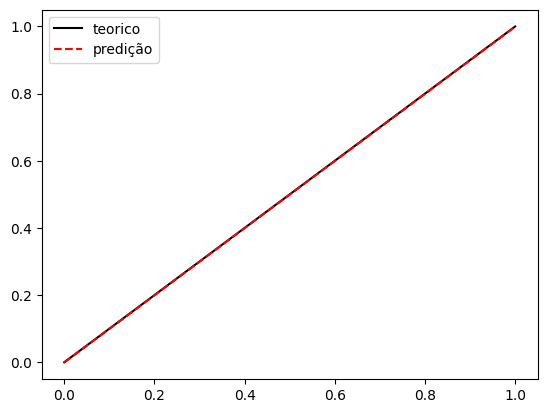

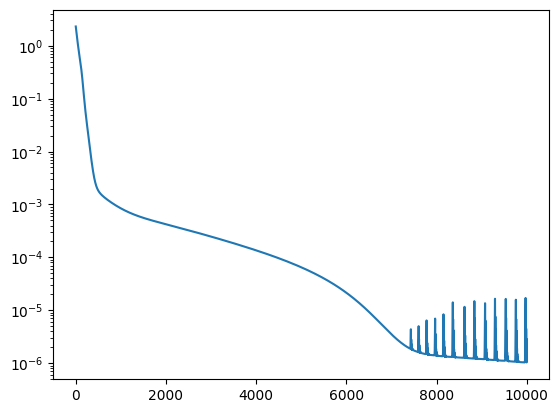

In [41]:

x_train = tc.linspace(0,1,30,requires_grad=True,device='cuda').reshape(-1,1)
y_train =  eq_movimento(x_0=0,v_=1,t_=x_train)

model = Regressao_1( 10,output=2 ).to("cuda") 
opt = tc.optim.Adam( params = model.parameters(),lr=0.001)  

LOSS = []
for epoch in range(10000):
    model.train()
    y_preds = model(x_train)     # output da rede
    solution = y_preds[:,0].reshape(x_train.shape)
    parametro = y_preds[:,1].reshape(x_train.shape)

    # Derivadas da rede 
    dydt  = tc.autograd.grad(solution, x_train, grad_outputs=tc.ones_like(solution),create_graph=True)[0]
    # Devidadas dos dados 
    dy_dt = tc.autograd.grad(y_train , x_train, grad_outputs=tc.ones_like(y_train), create_graph=True)[0]
    
    # Condição inicial x(0).
    loss_ic = (solution[0] -0)**2

    # Edo : dx/dt = v.
    loss_edo = tc.mean( (dydt - parametro.mean())**2 )

    # Edo : d(data)/dt = v.
    loss_data_edo = tc.mean( (dy_dt - parametro.mean() )**2 )

    # Fazer (data - solution)**2
    loss_data_solution =  tc.mean( (y_train - solution)**2 )
    
    # Penalização para quando parametro for diferente de sua media
    loss_const = tc.mean((parametro - parametro.mean()) ** 2)
    
    loss = tc.sum( loss_ic + loss_edo  + loss_data_edo + loss_data_solution + loss_const) #loss_ic + loss_edo + loss_const
    LOSS.append(loss.cpu().detach().numpy())
    #loss = loss_f(y_preds).sum()
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    
y_preds = model(x_train)     # output da rede
solution = y_preds[:,0]
parametro = y_preds[:,1]

print(f"\n| Train Loss: {loss.cpu().detach().numpy()} |","parametro:",parametro.mean().cpu().detach().numpy())

plt.plot(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),"k-" ,label="teorico")
plt.plot(x_train.cpu().detach().numpy(), solution.cpu().detach().numpy(),"r--",label="predição" )
plt.legend()
plt.show()

plt.yscale("log")
plt.plot(LOSS)
plt.show()

# a =Constante

## ML-std

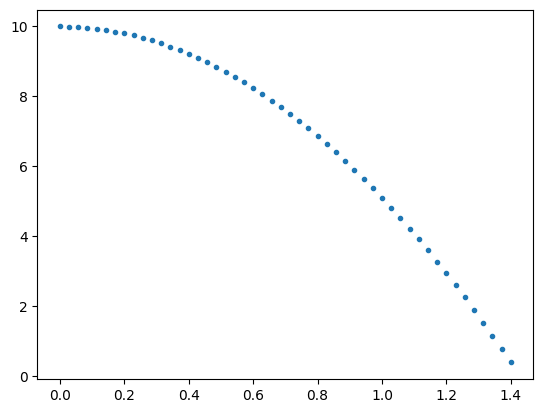

In [2]:
def eq_movimento(x_0,v_,a_,t_):
    return  x_0 + v_*t_ + a_*t_**2/2

t = np.linspace(0,1.4).reshape((-1, 1))
y = eq_movimento(x_0=10,v_=0,a_=-9.81,t_=t)
plt.plot(t,y,".")
plt.show()

Regressão linear

a:  [[-6.867]]
b:  [11.5696]


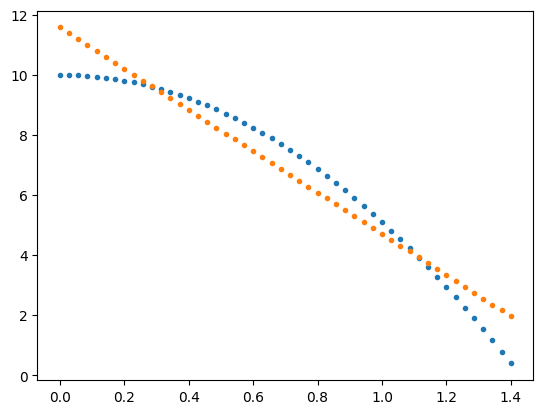

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(t,y)# FITANDO
print("a: ",reg.coef_)
print("b: ",reg.intercept_)

plt.plot(t,y,".")
plt.plot(t,reg.intercept_[0] + reg.coef_[0][0]*t,".")
plt.show()

Decision tree

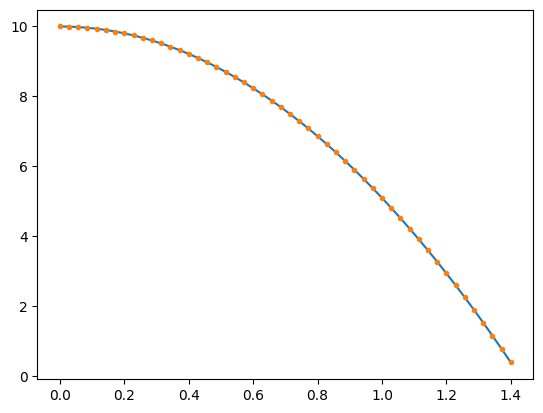

In [ ]:
from sklearn.tree import DecisionTreeRegressor

RT = DecisionTreeRegressor(criterion = "squared_error")
RT.fit(t,y)# FITANDO


predição = RT.predict(t)

plt.plot(t,y,"-")
plt.plot(t,predição,".")

plt.show()

Regressaõ polinomia

Coefficients:  [[ 0.0000000e+00  4.4408921e-16 -4.9050000e+00]]
b:  [10.]


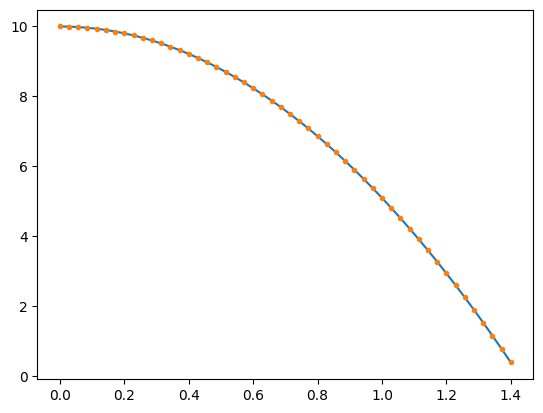

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)

t_poly = poly.fit_transform(t)

R = linear_model.LinearRegression()
train_y_ = R.fit(t_poly, y)
# The coefficients
print ('Coefficients: ', R.coef_)
print ('b: ',R.intercept_)

predição = R.intercept_[0]+ R.coef_[0][1]*t+ R.coef_[0][2]*t**2
plt.plot(t,y,"-")
plt.plot(t,predição,".")

plt.show()

## ML-Rede neural

Aprendendo a função com os dados

In [2]:
# Construindo o modelo    
class Regressao_1(nn.Module):
    def __init__(self, neuronio,output=1, creat_p=False ,N_of_paramater=1):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_2 = nn.Linear(neuronio,neuronio)
        self.layer_3 = nn.Linear(neuronio,output)
        self.A_layer = nn.Tanh()
        if creat_p == True:
            self.acceleration = nn.Parameter(tc.randn(N_of_paramater))

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_2(x))
        x = self.layer_3(x)
        return x

class Loss_edo(nn.Module):
    """
      Loss function para aprender a solução da edo.
      t   =  variável da edo. 
      icx = Condição inicial da posição.
      icv = Condição inicial da velocidade
      acceleration = Aceleração 
      lamdas[] = São os pesos de cada loss fucntion

      Essa informação é utilizada na:
          
        [0] loss_edo :    d^2 NN(0)/dt^2 - a = 0.
        [1] loss_edo2: dNN(0)/dt - v(0) - at = 0.
        [2] loss_icv :      dNN(0)/dt - v(0) = 0.
        [3] loss_icx :          NN(0) - x(0) = 0.
    """
    def __init__(self, t, icx, icv, acceleration, lambdas, y_true):
        super(Loss_edo,self).__init__()

        self.t_ = t
        self.x0 = icx
        self.v0 = icv
        self.a_ = acceleration
        self.c1 = lambdas[0]
        self.c2 = lambdas[1]
        self.c3 = lambdas[2]
        self.c4 = lambdas[3]
        self.y_true_ = y_true

    def forward(self,y_pred):
        dydt = tc.autograd.grad(y_pred, self.t_, grad_outputs=tc.ones_like(y_pred), create_graph=True)[0]
        d2ydt2 = tc.autograd.grad(dydt, self.t_, grad_outputs=tc.ones_like(dydt), create_graph=True)[0]
        
        # v - x0 - at = 0
        loss_ode_first_orden = tc.sum( (dydt - self.v0 - self.a_*self.t_)**2 )
        
        # The residual of the second-order ODE
        loss_ode_second_orden = tc.sum( (d2ydt2 - self.a_)**2 )

        # Condição inicial x0 
        loss_icx = (y_pred[0] - self.x0)**2

        # Condição inicial v0 
        loss_icx = (dydt[0] - self.v0)**2

        return self.c1*loss_ode_first_orden + self.c2*loss_ode_second_orden + self.c3*loss_icx + self.c4*loss_icx

class Loss_parametro(nn.Module):
    def __init__(self,x_0,v_0,t,lambdas,y_true):
        super().__init__()
        self.x0 = x_0
        self.v0 = v_0
        self.t_ = t 
        self.c1 = lambdas[0]
        self.c2 = lambdas[1]
        self.y_true_ = y_true

    def forward(self, acceleration):
        # talvez adicionar a derivada
        # y  =  x_0 + v_*t_ + a_*t_**2/2
        loss_solution = tc.mean((self.y_true_ - self.x0 -self.v0*self.t_ - acceleration*self.t_**2/2)**2)
        
        # podemos impor que independe do input o parametro deve ser igual
        v_medio = acceleration.mean()
        loss_const = tc.mean((acceleration - v_medio)**2)
        return self.c1*loss_solution + self.c2*loss_const

class Loss_edo_parametro(nn.Module):
    """
      Loss function para aprender a solução da edo.
      t   =  variável da edo. 
      icx = Condição inicial da posição.
      icv = Condição inicial da velocidade
      lamdas[] = São os pesos de cada loss fucntion

      Essa informação é utilizada na:
          
        [0] loss_edo2: dNN(0)/dt - v(0) - at = 0. 
        [1] loss_edo :      d2NN(0)/dt2 - a  = 0.
        [2] loss_data:             NN - data = 0.
        [3] loss_data_edoe : ddata/dt - v(0) - at = 0.
        [4] loss_data_edoe : d2data/dt2 - a  = 0.
        [5] loss_icx : Condição inicial x0.  
        [6] loss_icv : Condição inicial v0.
        
    """
    def __init__(self, t, icx, icv, lambdas, y_true):
        super(Loss_edo_parametro,self).__init__()

        self.t_ = t
        self.x0 = icx
        self.v0 = icv
        self.c1 = lambdas[0]
        self.c2 = lambdas[1]
        self.c3 = lambdas[2]
        self.c4 = lambdas[3]
        self.c5 = lambdas[4]
        self.c6 = lambdas[5]
        self.c7 = lambdas[6]
        self.y_true_ = y_true
        # Devidadas dos dados 
        self.dy_dt = tc.autograd.grad(y_true , t, grad_outputs=tc.ones_like(y_true), create_graph=True)[0]   
        self.d2y_dt2 = tc.autograd.grad(self.dy_dt , t, grad_outputs=tc.ones_like(self.dy_dt), create_graph=True)[0]   

    def forward(self,y_pred,a_):
        dydt = tc.autograd.grad(y_pred, self.t_, grad_outputs=tc.ones_like(y_pred), create_graph=True)[0]
        d2ydt2 = tc.autograd.grad(dydt, self.t_, grad_outputs=tc.ones_like(dydt), create_graph=True)[0]
        
        # v - x0 - at = 0
        loss_ode_dydt = tc.sum( (dydt - self.v0 - a_*self.t_)**2 )
                
        # The residual of the second-order ODE
        loss_ode_d2ydt2 = tc.sum( (d2ydt2 - a_)**2 )
               
        # Usando os dado experimentais 
        loss_data = tc.mean( (self.y_true_ - y_pred )**2 )
        
        # Usando os dado experimentais na equação diferencial dydt = v0 + at .
        loss_data_edo_dydt = tc.mean( (self.dy_dt - self.v0 - a_*self.t_)**2 )        
        
        # Usando os dado experimentais na equação diferencial d2ydt2 = a .
        loss_data_edo_d2ydt2 = tc.mean( (self.d2y_dt2 - a_)**2 )        
        
        # Condição inicial x0 
        loss_icx = (y_pred[0] - self.x0)**2

        # Condição inicial v0 
        loss_icx = (dydt[0] - self.v0)**2

        return self.c1*loss_ode_dydt + self.c2*loss_ode_d2ydt2 + self.c3*loss_data + self.c4*loss_data_edo_dydt +self.c5*loss_data_edo_d2ydt2 + self.c6*loss_icx + self.c7*loss_icx


In [3]:
def eq_movimento(x_0,v_,a_,t_):
    return  x_0 + v_*t_ + a_*t_**2/2

# Criando os dados de treino
x_train = tc.linspace(0,1.4,30,requires_grad=True).reshape(-1,1)
y_train =  eq_movimento(x_0=10,v_=0,a_=-9.80665,t_=x_train)

Utilizando a rede neural para fitar os dados, aprendizado supervisonado.

| Train Loss: 0.000713817251380533 | 


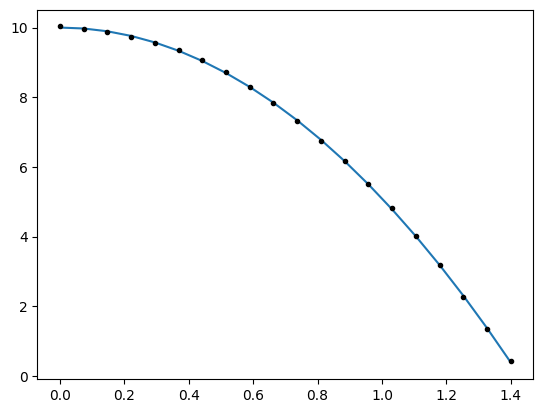

In [12]:
model = Regressao_1(neuronio=5)
loss_fn = nn.MSELoss()
opt = tc.optim.Adam(params=model.parameters(),lr=0.01)

epochs = 2000
for epoch in range(epochs):
    model.train()
    y_preds = model(x_train)
    loss = loss_fn(y_preds, y_train)
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

model.eval()
with tc.inference_mode():
    y_preds_test = model(x_train)
    loss = loss_fn(y_preds_test,y_train)
    print(f"| Train Loss: {loss} | ")

plt.plot(x_train.detach().numpy(),y_train.detach().numpy(),"-" )
plt.plot(x_train.detach().numpy(),y_preds_test.detach().numpy(),"k." )
plt.show()

Aprendendo o parametro da equação (Aceleração)

| Train Loss: 5.78404865336779e-07 | Parametre: -9.8060302734375 | Erro :0.0006200000061653554 


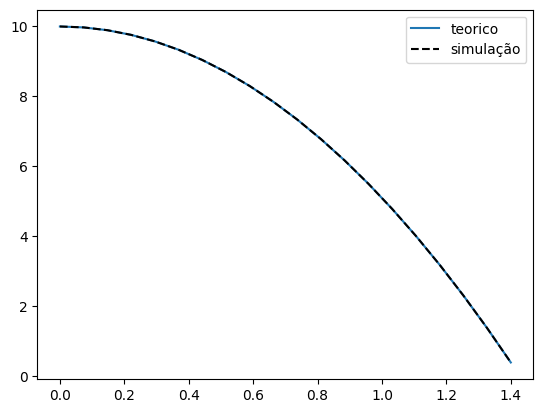

In [35]:
model = Regressao_1(neuronio=10)
opt   = tc.optim.Adam(params=model.parameters(),lr=0.01)
loss_f = Loss_parametro(x_0=10,v_0=0,t=x_train,lambdas=[1,1],y_true=y_train)

for epoch in range(10000):
    model.train()

    y_preds = model(x_train)
    loss = loss_f(y_preds)
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

y_preds = model(x_train)
print(f"| Train Loss: {loss} | Parametre: {y_preds.mean()} | Erro :{tc.round(abs(y_preds.mean()+ 9.80665),decimals=5)} ")

plt.plot(x_train.detach().numpy(), y_train.detach().numpy(),"-", label="teorico")
f = 10 + y_preds.mean()*x_train**2/2
plt.plot(x_train.detach().numpy(), f.detach().numpy(),"k--", label=f"simulação" )
plt.legend()
plt.show()

Usando a rede neural como solução da equação diferencial

| Train Loss: tensor([0.0006], grad_fn=<AddBackward0>) | 


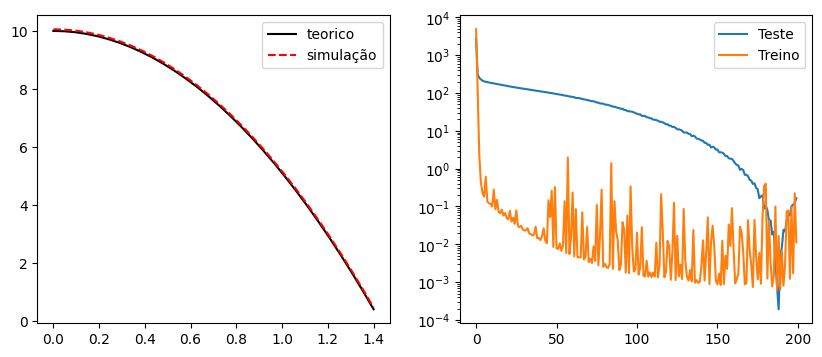

In [8]:
x_teste = tc.linspace(0,1.4,50,requires_grad=True).reshape(-1,1)
y_test =  eq_movimento(x_0=10,v_=0,a_=-9.80665,t_=x_teste)

model = Regressao_1(neuronio=7)
opt   = tc.optim.Adam(params=model.parameters(),lr=0.01)
loss_f = Loss_edo( t = x_train, 
                  icx = 10, 
                  icv = 0, 
                  acceleration = -9.8066,
                  lambdas = [1,1,1,1],
                  y_true = y_train)
LOSS = []
LOSS2 = []
for epoch in range(20000):
    model.train()
    y_preds = model(x_train)
    loss = loss_f(y_preds)
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    if epoch % 100 == 0 :
        y_preds_test = model(x_teste)
        loss2 = tc.sum((y_preds_test - y_test)**2)
        #print(f"|Epoch:{epoch}|Loss: {loss.detach().numpy()} | ")
        LOSS2.append(loss2.detach().numpy())
        LOSS.append(loss.detach().numpy())
        
y_preds = model(x_train)
print(f"| Train Loss: {loss} | ")
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(x_train.detach().numpy(), y_train.detach().numpy(),"k-", label="teorico")
ax[0].plot(x_train.detach().numpy(), y_preds.detach().numpy(),"r--", label=f"simulação" )
ax[0].legend()

ax[1].plot(LOSS2,label="Teste")
ax[1].plot(LOSS,label="Treino")
ax[1].legend()
ax[1].set_yscale('log')
plt.show()

Aprendendo a função e os parâmetro da edo

| Train Loss: [0.06457008] | Parametre: [-9.805388] | Erro :[0.00126] 


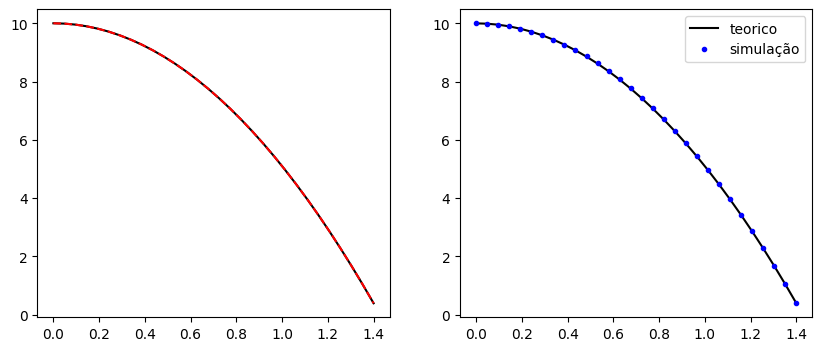

In [28]:
model = Regressao_1(neuronio=10,creat_p=True)
opt   = tc.optim.Adam(params=model.parameters(),lr=0.01)
loss_f = Loss_edo_parametro(t = x_train,
                            icx = 10,
                            icv = 0,
                            lambdas = [1,1,1,1,1,1,1],
                            y_true = y_train)

for epoch in range(10000):
    model.train()
    y_preds = model(x_train)     # output da rede
    parametro = model.acceleration # chamando o parametro 
    loss = loss_f(y_preds,parametro)
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

y_preds = model(x_train)     # output da rede
parametro = model.acceleration # chamando o parametro 
f = 10 + parametro*x_train**2/2

print(f"| Train Loss: {loss.detach().numpy()} | Parametre: {parametro.detach().numpy()} | Erro :{tc.round(abs(parametro+ 9.80665),decimals=5).detach().numpy()} ")
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(x_train.detach().numpy(), y_train.detach().numpy(),"k-", label="teorico")
ax[0].plot(x_train.detach().numpy(), f.detach().numpy(),"r--", label=f"simulação" )

ax[1].plot(x_train.detach().numpy(), y_train.detach().numpy(),"k-", label="teorico")
ax[1].plot(x_train.detach().numpy(), y_preds.detach().numpy(),"b.", label=f"simulação" )
plt.legend()
plt.show()

# Oscilador harmonico

In [2]:
# Construindo o modelo    
class Regressao_1(nn.Module):
    def __init__(self, neuronio,output=1, creat_p=False ,N_of_paramater=1):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_2 = nn.Linear(neuronio,neuronio)
        self.layer_3 = nn.Linear(neuronio,output)
        self.A_layer = nn.Tanh()
        if creat_p == True:
            self.acceleration = nn.Parameter(tc.randn(N_of_paramater))

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_2(x))
        x = self.layer_3(x)
        return x

class Loss_OHS(nn.Module):
    """
      Loss function para aprender a solução da edo.
      t   =  variável da edo. 
      icx = Condição inicial da posição.
      icv = Condição inicial da velocidade
      lamdas[] = São os pesos de cada loss fucntion

      Essa informação é utilizada na:
          
        [1] loss_edo : d2x/dt2 +gamma*dx/dt + kx = 0.
        [2] loss_icx : Condição inicial x0.  
        [3] loss_icv : Condição inicial v0.
        
    """
    def __init__(self, t, icx, icv, data):
        super(Loss_OHS,self).__init__()
        self.t_ = t
        self.x0 = icx
        self.v0 = icv
        self.data_ = data  

    def forward(self,y_pred,pamametros):
        k  = pamametros[0]
        m  = pamametros[1]
        zeta  = pamametros[2]
        
        dydt = tc.autograd.grad(y_pred, self.t_, grad_outputs=tc.ones_like(y_pred), create_graph=True)[0]
        d2ydt2 = tc.autograd.grad(dydt, self.t_, grad_outputs=tc.ones_like(dydt), create_graph=True)[0] 
                
        # The residual of the second-order ODE
        loss_ode_d2ydt2 = tc.sum( (d2ydt2 + 2*zeta*tc.sqrt(k/m)*dydt + (k/m)*y_pred)**2 )
                           
        # Condição inicial x0 
        loss_icx = (y_pred[0] - self.x0)**2

        # Condição inicial v0 
        loss_icx = (dydt[0] - self.v0)**2
        
        # loss data
        loss_data = tc.sum( (self.data_ - y_pred)**2 )

        return loss_ode_d2ydt2 + loss_icx + loss_icx + loss_data


In [3]:
def soluçao_OHM_tc(k,m,zeta,t):
    omega_n = tc.sqrt(k / m)  # Frequência natural

    # Função para calcular a posição do oscilador no tempo t
    def position(t):
        return tc.exp(-zeta * (tc.sqrt(1 - zeta**2) * omega_n) * t) * tc.cos(tc.sqrt(1 - zeta**2) * omega_n * t )
    # Calcular a posição correspondente para cada tempo
    x = position(t)
    return x

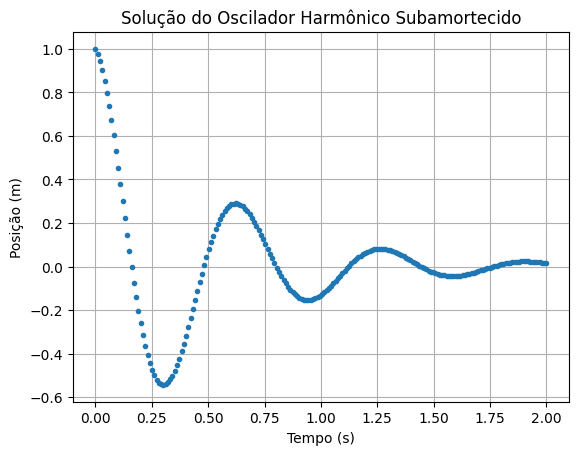

In [10]:
t = tc.linspace(0, 2, 200,requires_grad=True).reshape((-1,1))

# Calcular a posição correspondente para cada tempo
y = soluçao_OHM_tc(tc.tensor(100),tc.tensor(1),tc.tensor(0.2),t)

# Plotar a posição em função do tempo
plt.plot(t.detach().numpy(), y.detach().numpy(),".")
plt.xlabel('Tempo (s)')
plt.ylabel('Posição (m)')
plt.title('Solução do Oscilador Harmônico Subamortecido')
plt.grid(True)
plt.show()


| Train Loss: [4.023868] | Parametre: [0.8277276  0.02336532 0.44128385]  


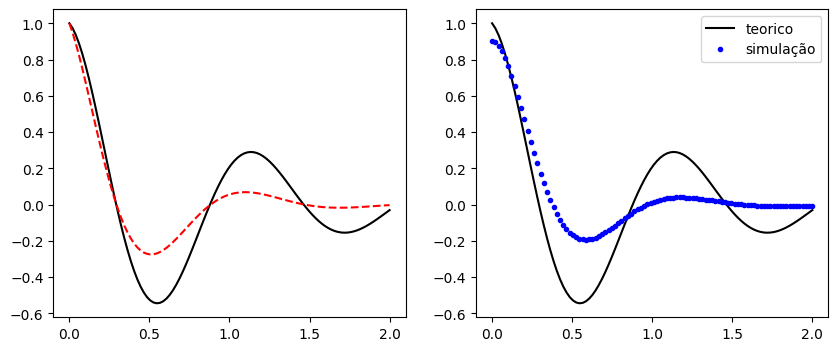

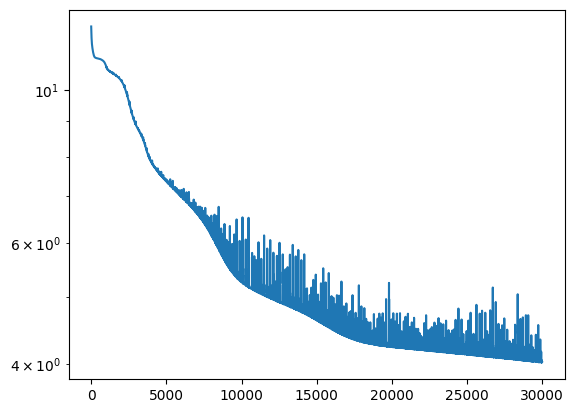

In [28]:
device = 'cuda'
t = tc.linspace(0, 2, 100,requires_grad=True).reshape((-1,1)).to(device)
y = soluçao_OHM_tc(tc.tensor(30),tc.tensor(1),tc.tensor(0.2),t).to(device)

model = Regressao_1(neuronio=5,creat_p=True,N_of_paramater=3).to(device)
opt   = tc.optim.Adam(params=model.parameters(),lr=0.001)
loss_f = Loss_OHS(t = t,icx = 1,icv = 0,data= y).to("cuda")
LOSS = []
for epoch in range(30000):
    model.train()
    y_preds = model(t)     # output da rede
    parametro = model.acceleration # chamando o parametro 
    loss = loss_f(y_preds,parametro)
    LOSS.append(loss.cpu().detach().numpy())
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()


y_preds = model(t)     # output da rede
parametro = model.acceleration # chamando o parametro 
f = soluçao_OHM_tc( k = parametro[0].cpu() , m =  parametro[1].cpu() , zeta = parametro[2].cpu(), t = t )

print(f"| Train Loss: {loss.cpu().detach().numpy()} | Parametre: {parametro.cpu().detach().numpy()}  ")
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(t.cpu().detach().numpy(), y.cpu().detach().numpy(),"k-", label="teorico")
ax[0].plot(t.cpu().detach().numpy(), f.cpu().detach().numpy(),"r--", label=f"simulação" )


ax[1].plot(t.cpu().detach().numpy(), y.cpu().detach().numpy(),"k-", label="teorico")
ax[1].plot(t.cpu().detach().numpy(), y_preds.cpu().detach().numpy(),"b.", label=f"simulação" )
plt.legend()
plt.show()
plt.plot(LOSS)
plt.yscale("log")
plt.show()

| Train Loss: [nan] | Parametre: [nan nan nan]  


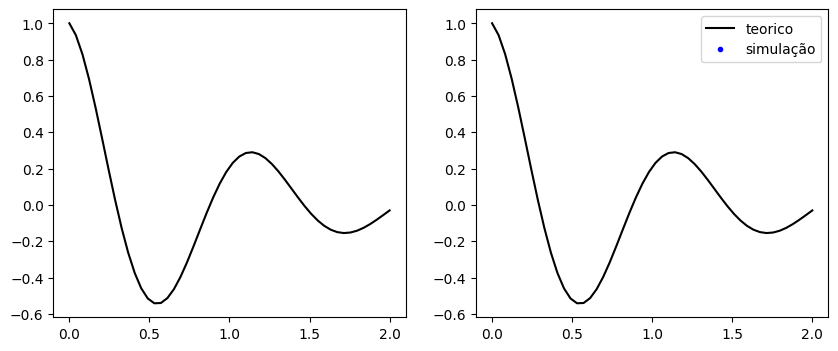

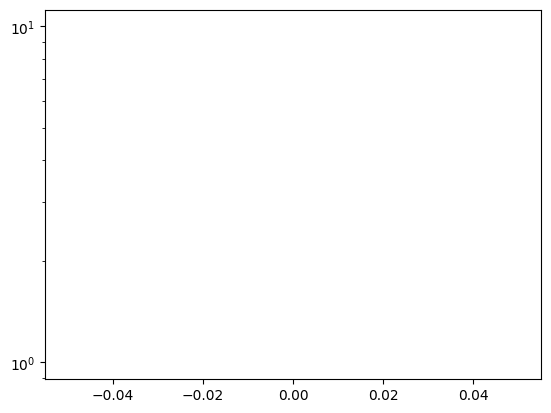

In [25]:

y_preds = model(t)     # output da rede
parametro = model.acceleration # chamando o parametro 
f = soluçao_OHM_tc( k = parametro[0].cpu() , m =  parametro[1].cpu() , zeta = parametro[2].cpu(), t = t )

print(f"| Train Loss: {loss.cpu().detach().numpy()} | Parametre: {parametro.cpu().detach().numpy()}  ")
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(t.cpu().detach().numpy(), y.cpu().detach().numpy(),"k-", label="teorico")
ax[0].plot(t.cpu().detach().numpy(), f.cpu().detach().numpy(),"r--", label=f"simulação" )


ax[1].plot(t.cpu().detach().numpy(), y.cpu().detach().numpy(),"k-", label="teorico")
ax[1].plot(t.cpu().detach().numpy(), y_preds.cpu().detach().numpy(),"b.", label=f"simulação" )
plt.legend()
plt.show()
plt.plot(LOSS)
plt.yscale("log")
plt.show()